In [188]:
import numpy as np
import pydicom
import cv2
import torch
import segmentation_models_pytorch as smp
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import re

margin = 70
device = torch.device('cpu')

def export_num(string):
    # 파일이름에서 숫자를 추출
    # ex) "00006021_converted_138.dcm" -> 138
    find_num = re.compile('[0-9]+')
    number = find_num.findall(string[-10:])
    return int(number[0])


def load_image(dir_path):
    # dir_path에 들어있는 dcm파일을 읽어서 3d numpy array로 반환
    file_list = os.listdir(dir_path)
    dcm_list = []
    for idx, file in enumerate(file_list):
        if "dcm" in file:
            dcm_list.append(file)     
    file_df = pd.DataFrame(
                            {"file_name" : dcm_list},
                            index = list(map(export_num, dcm_list))
                           ).sort_index()
    image_3d = np.zeros((512,512, len(file_df)))
    for z, image_2d_path in enumerate(dcm_list):
        image_2d = np.array(pydicom.dcmread(dir_path + '/' + file_df.iloc[z,0]).pixel_array)
        image_3d[:,:,z] = image_2d
    return image_3d

def normalize(image):
    # 입력 받은 numpy array를 0.3 quantile과 0.99 quantile을 기준으로 min max scaleing
    min_val = np.quantile(image.reshape(-1), 0.3)
    max_val = np.quantile(image.reshape(-1), 0.99)
    # 1차 threshold 적용                   
    over_idx  = (image > max_val)
    under_idx = (image < min_val)
    image[over_idx]  = max_val
    image[under_idx] = min_val
    normalized_3d = (image - min_val) / (max_val - min_val)# * 255    
    #normalized_3d = normalized_3d.astype(np.uint8)#[..., np.newaxis]
    return normalized_3d

def apply_margin(image, margin):
    # 입력 받은 이미지의 상하좌우로 margin을 적용하고
    # 원본 크기로 resize하여 반환
    image_margin = np.zeros([512, 512, image.shape[2]])
    for z in range(image.shape[2]):
        sample = image[margin:-margin,margin:-margin, z].copy()
        sample = sample.astype(np.uint8)
        image_margin[:,:,z] = cv2.resize(sample, (512, 512))
    return image_margin    

def predict(image, model):
    # 3차원 입력을 받아서 추론하고 출력 [샘플 수, 세로축, 가로축]
    #image = image[..., np.newaxis]
    image = image.astype('float32')[:,np.newaxis,...]#[샘플수, 채널 수(1), 세로축, 가로축]
    image_tensor = torch.FloatTensor(image).to(device)
    predict_mask = model.predict(image_tensor).numpy()
    return predict_mask


def gen_padding(image, mul = 4):
    # saggital plane(2차원)을 입력으로 받음
    # 입력받은 이미지의 z축을 4배로 resize
    # 가로 세로 비율을 유지하면서 z축을 512로 resize
    # y축을 기준으로 상하 padding을 적용하여 512,512이미지 생성
    
    # (x_size, z_size)크기의 이미지 입력, x_size == 512
    # x_size : x축 길이, 512로 고정 o
    x_size = image.shape[0]
    # z_size : x축의 길이, 고정 x
    z_size = image.shape[1]
    
    
    # axis 1의 크기를 4배로 resize
    mul_z_size =  z_size*mul
    resized_mul = cv2.resize(image, (x_size, mul_z_size)).T
    
    # axis 1 크기를 512로 바꿀 때,
    # axis 0의 크기 계산
    # x_size : mul_z_size  = ??? : 512
    # ??? = 512 * x_size / mul_z_size
    x_resize = int(512 * x_size / mul_z_size)
    
    
    # 가로 세로 비율을 유지하면서 axis 1의 크기를 512로 resize
    resized_512 = cv2.resize(resized_mul, (x_resize, 512)).T
    padding_image = np.zeros([512, 512])
    padding_size = (512 - x_resize) // 2
    padding_image[padding_size:padding_size + resized_512.shape[0],:] = resized_512    
    return padding_image


def mask_to_loc(sagittal_mask):
    # 모델이 예측한 sagittal_mask를 입력으로 받음
    # sagittal_mask를 바탕으로 l3의 위치를 계산하여 반환
    col_index = sagittal_mask[:,:].sum(axis = 0) > sagittal_mask.shape[1]/2
    re_pred = np.zeros(sagittal_mask.shape)
    re_pred[:, col_index] = 1
    l3_loc = int(np.median(np.argwhere(col_index)))
    return l3_loc

def mask_to_area(l3_mask, meta_data):
    musle = (l3_mask == 0)
    visceral = (l3_mask == 1)
    subcutaneous = (l3_mask == 2)

    abdomen = musle + visceral + subcutaneous
    abdomen_img = abdomen.copy().astype(np.uint8)
    contours, _ = cv2.findContours(abdomen_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    max_area = 0
    for cont in contours:
        area = cv2.contourArea(cont)
        if area > max_area:
            max_area = area
            max_contour = cont

    abdomen_area = max_area
    musle_ratio = musle.sum() / abdomen_area
    visceral_ratio = visceral.sum() / abdomen_area
    subcutaneous_ratio = subcutaneous.sum() / abdomen_area

    other_ratio = 1 - musle_ratio\
                    - visceral_ratio\
                    - subcutaneous_ratio    
    meta_data.loc['muscle', 'ratio'] = musle_ratio
    meta_data.loc['visceral', 'ratio'] = visceral_ratio
    meta_data.loc['subcutaneous', 'ratio'] = subcutaneous_ratio
    meta_data.loc['other', 'ratio'] = other_ratio
    return meta_data

In [189]:
models_dir = 'models'
input_dir = 'input'
output_dir = 'output'

In [199]:
sagittal.shape

(512, 257)

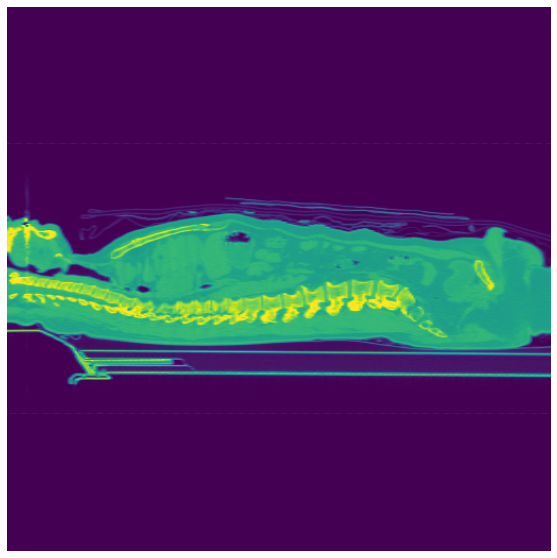

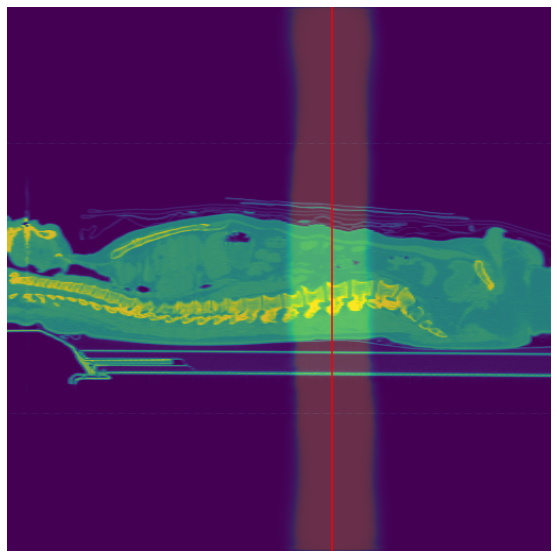

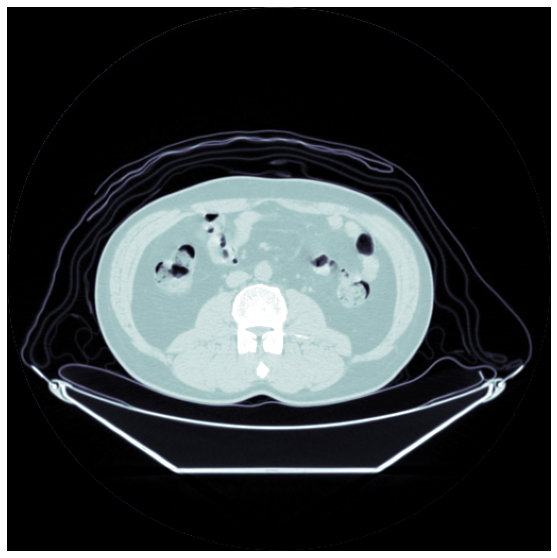

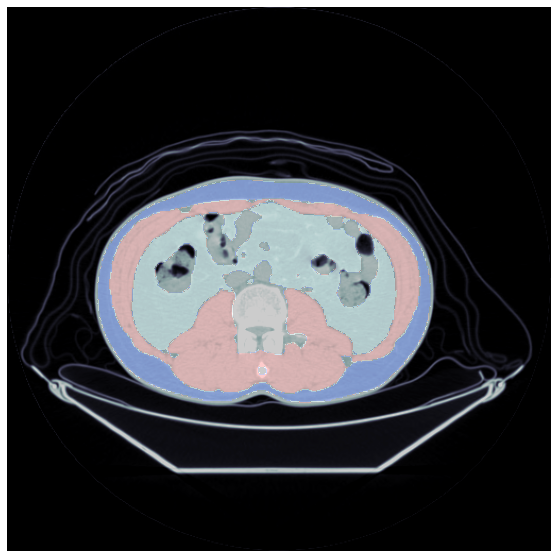

,ratio
muscle,0.331449
visceral,0.301099
subcutaneous,0.201028
other,0.166424


In [226]:
with torch.no_grad():    
    #모델 불러오기-------------------------------------------------------------
    # abdomen영역을 detect 모델
    detect_model = torch.load(models_dir  + "/" + "detect_model.pth").to(device)
    # abdomen에서 musle, visceral, subcutaneous를 segment 모델
    segment_model = torch.load(models_dir + "/" + "segment_model.pth").to(device)
    
    
    #3차원 이미지 불러오기 불러오기--------------------------------------------
    image_3d = load_image(input_dir)
    
    # detect abdomen
    sagittal = image_3d[:,256,:]
    sagittal_normal = normalize(sagittal)
    sagittal_padding = gen_padding(sagittal_normal)[np.newaxis, ...]
    sagittal_mask = predict(sagittal_padding, detect_model)[0,0,...]
    
    l3_loc_padding = mask_to_loc(sagittal_mask) #추가 정의 필요
    l3_loc = int(sagittal.shape[1] * (l3_loc_padding / sagittal.shape[0]))
    

    plt.figure(figsize = (10,10))
    plt.imshow(sagittal_padding[0,...])
    plt.savefig(output_dir + "/" + 'sagittal.png')
    ax = plt.gca()
    ax.axis('off')
    plt.show()

    plt.figure(figsize = (10,10))
    plt.imshow(sagittal_padding[0,...])
    plt.imshow(sagittal_mask, alpha = 0.2)
    plt.axvline(l3_loc_padding, c = 'red')
    ax = plt.gca()
    ax.axis('off')
    plt.savefig(output_dir + "/" + 'sagittal_overray.png')
    plt.show()
    #--------------------------------------------------------------------------
    
    # segment abdomen
    predict_mask_3d = np.zeros([512,512,40])
    window = 1 # 연상량이 충분하다면 20으로 설정
    horizontal_stack = image_3d[:,:,l3_loc - window : l3_loc + window].transpose(2, 0, 1)
    #horizontal_stack = apply_margin(horizontal_stack, margin = 70)
    # 정규화
    horizontal_normal  = normalize(horizontal_stack)
    # 예측
    sagittal_mask = predict(horizontal_normal, segment_model)#[0,0,...]
    horizontal_mask = sagittal_mask.transpose([0, 2, 3, 1]).argmax(axis = 3)
    horizontal_mask = (horizontal_mask * 255 / 3).astype(np.uint8)
    
    plt.figure(figsize = (10,10))
    plt.imshow(horizontal_normal[window,...], cmap = 'bone')
    ax = plt.gca()
    ax.axis('off')
    plt.savefig(output_dir + "/" + 'horizontal.png')
    plt.show()

    plt.figure(figsize = (10,10))
    plt.imshow(horizontal_normal[window,...], cmap = 'bone')
    plt.imshow(horizontal_mask[window,...], alpha = 0.2, cmap = 'flag')
    ax = plt.gca()
    ax.axis('off')
    plt.savefig(output_dir + "/" + 'horizontal_overray.png')
    plt.show()
    #--------------------------------------------------------------------------    
    meta_data = pd.DataFrame([0., 0., 0., 0.],
                             columns = ['ratio'])
    meta_data.index = ['muscle', 'visceral','subcutaneous', 'other']

    for z in range(horizontal_mask.shape[0]):
        l3_mask = horizontal_mask[z] / 255 * 3 
        meta_sample = mask_to_area(l3_mask, meta_data)
        ratios.append(meta_sample.ratio.values.copy())

    meta_data['ratio'] = np.vstack(ratios).mean(axis = 0)
    meta_data.to_csv(output_dir + '/' + "meta_data.csv")
    display(meta_data)

In [231]:
ds = pydicom.filereader.dcmread("input/00006021_converted_0.dcm")

In [233]:
ds = pydicom.filereader.dcmread("input/00006021_converted_256.dcm")

In [238]:
ds('Image Position')

TypeError: 'FileDataset' object is not callable

In [236]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 212
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113619.2.55.1.1762937917.2244.1162775997.758.257
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.410.200003.2020819.5.2.1
(0002, 0013) Implementation Version Name         SH: 'Anonymized'
(0002, 0016) Source Application Entity Title     AE: 'Anonymized'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0012) Instance Creation Date              DA: 'Anonymized'
(0008, 0013) Instance Creation Time              TM: 'Anonymized'
(0008, 0016) SOP Clas

In [ ]:
if __name__ == "__main__":
    # input path
    if sys.argv[1] == '-input_dir':
        input_dir = sys.argv[2]
    if sys.argv[3] == '-output_dir':
        output_dir = sys.argv[4]
    if sys.argv[5] == '-models_dir':
        models_dir = sys.argv[6]
        
    with torch.no_grad():
        #set path, model
        detect_model = torch.load(models_dir + "detect_model.pth").to(device)
        segment_model = torch.load(models_dir+ "segment_model.pth").to(device)
        
        # load 3d image
        image_3d = load_image(img_path)
        
        # detect abdomen
        sagittal = image_3d[:,256,:]
        sagittal_normal = normalize(sagittal)
        sagittal_mask = predict(sagittal_normal, detect_model)
        l3_loc = mask_to_loc(sagittal_mask) #추가 정의 필요
        
        # segment abdomen
        predict_mask_3d = np.zeros([512,512,40])
        for z in range(l3_loc - 20, l3_loc + 20):
            horizontal = image_3d[:,:,z]
            horizontal = apply_margin(horizontal, margin = 70)
            horizontal_normal  = normalize(horizontal)
            horizontal_mask = predict(horizontal_normal, segment_model)
            horizontal_mask = (horizontal_mask * 255 / 3).astype(np.uint8)
            predict_mask_3d[:,:,z - l3_loc + 20] = horizontal_mask
            
        # sample horizontal plane에 예측한 mask 중첩하여 보여주기
        predict_mask_l3 = predict_mask_3d[:,:,20]
        horizontal_l3 = image_3d[:,:,l3_loc]
        
        # sample horizontal plane에 예측한 mask 에서 근육, 내장지방, 피하지방 값 csv로 저장하기
        
        
        # 부피 계산하기
        
        # preprocessing
        image_tensor = preprocessing(image)
        # predict
        predict_mask = predict(image_tensor, model)
        predict_mask = (predict_mask * 255 / 3).astype(np.uint8)
        #cv2.imwrite(save_path + 'input.png', image_tensor)
        #cv2.imwrite(save_path + 'output.png', predict_mask)
    
        print((predict_mask == 0).sum() / len(predict_mask.reshape(-1)) * 100)
        print((predict_mask == 1* 255/ 3).sum() / len(predict_mask.reshape(-1)) * 100)
        print((predict_mask == 2* 255/ 3).sum() / len(predict_mask.reshape(-1)) * 100)
        print((predict_mask == 3* 255/ 3).sum() / len(predict_mask.reshape(-1)) * 100)

